# Sources

https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590

https://data.worldbank.org/indicator/SI.POV.GINI

https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD

https://population.un.org/wpp/Download/Standard/CSV/

In [3]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Importing the data

GDP = pd.read_csv('./gdp-per-capita-worldbank.csv', sep=',')
Population = pd.read_csv('./populationbysex.csv', sep=',')
Covid = pd.read_csv('./covid-june.csv', sep=',')
gini = pd.read_csv('./gini.csv', sep=',')

In [5]:
#Cleaning and preparing the data

In [6]:
GDP.insert(1, 'Country', GDP['Entity'])
del GDP['Entity']

In [7]:
GDP.rename(columns = {'GDP per capita (int.-$) (constant 2011 international $)':'GDP/capita'}, inplace=True)

In [8]:
Population.insert(2, 'Country', Population['Location'])
del Population['Location']

In [9]:
Population.rename(columns = {'Time':'Year'}, inplace=True)

In [10]:
del GDP['Code']

In [11]:
Population.drop(Population.columns.difference(['Country','Year', 'PopMale', 'PopFemale', 'PopTotal']), 1, inplace=True)

In [12]:
#Selecting the latest population data

print('Pop: ', Population['Year'].max(), 'GDP: ', GDP['Year'].max())

Pop:  2100 GDP:  2017


In [13]:
Population['Year'] = Population['Year'].astype(str)
Pop_2017 = Population['Year'].str.contains('2017')
Latest_Pop = pd.DataFrame(Population[Pop_2017])

In [14]:
GDP['Year'] = GDP['Year'].astype(str)
GDP_2017 = GDP['Year'].str.contains('2017')
Latest_GDP = pd.DataFrame(GDP[GDP_2017])

In [15]:
Data = Latest_GDP.merge((Latest_Pop), on='Country', how='inner')

In [16]:
del Data['Year_y']
Data.rename(columns = {'Year_x':'Year'}, inplace=True)

In [17]:
del Covid['year']
del Covid['geoId']
del Covid['popData2018']
del Covid['day']
del Covid['month']
del Covid['dateRep']
del Covid['countryterritoryCode']

In [18]:
Covid.rename(columns = {'countriesAndTerritories':'Country'}, inplace=True)

In [19]:
#The data displays the number of new cases and deaths per day, 
#so we need to sum all of the values and add them to new columns

Covid['total_cases'] = ''
Covid['total_deaths'] = ''
for country in Covid['Country'].unique():
    #each_country = Covid['Country'].str.contains(country)
    cases_per_country = Covid.loc[Covid['Country']==country, 'cases'].sum()  
    Covid.loc[Covid['Country']==country, 'total_cases'] = cases_per_country
    
    death_country = Covid.loc[Covid['Country']==country, 'deaths'].sum()
    Covid.loc[Covid['Country']==country, 'total_deaths'] = death_country

In [20]:
del Covid['cases']
del Covid['deaths']

In [21]:
Data = Data.merge(Covid, on='Country', how='inner')

In [22]:
#The data will have many repeated rows as they had the cases and deaths per day, so we need to drop duplicates

Data = Data.drop_duplicates(subset='Country')
Data = Data.reset_index(drop=True)

In [23]:
#Adding the USA to the dataframe
#Each key is a column, and the panda series will set the rows 
usa_data = ['USA', 62795, 161480, 168080, 328200, 'America', 2016855, 112789]

USA = {'Country': pd.Series('USA'),
      'GDP/capita': pd.Series(62795),
       'PopMale': pd.Series(161480),
       'PopFemale': pd.Series(168080),
       'PopTotal': pd.Series(328200),
       'continentExp': pd.Series('America'),
       'total_cases': pd.Series(2016855),
       'total_deaths': pd.Series(112789)
      }
USA = pd.DataFrame(USA)

In [24]:
Data = Data.append(USA, ignore_index=True)

In [25]:
Data['mortality/country'] = Data['total_deaths']/Data['total_cases']
Data['male_pop_percentage'] = Data['PopMale']/Data['PopTotal']

In [26]:
del gini['cca2']
del gini['pop2020']
gini.rename(columns = {'name':'Country'}, inplace=True)

In [27]:
usa_gini = gini['Country'].str.contains('United')
gini[usa_gini]

,Country,giniIndex
37,United Kingdom,32.4
108,United States,45.0


In [28]:
gini.at[108, 'Country'] = 'USA'

In [29]:
Data = Data.merge(gini, on='Country', how='inner')
Data.rename(columns = {'giniIndex_x':'gini index'}, inplace=True)

In [30]:
test_usa = Data['Country'].str.contains('USA')
Data[test_usa]

,Country,Year,GDP/capita,PopMale,PopFemale,PopTotal,continentExp,total_cases,total_deaths,mortality/country,male_pop_percentage,giniIndex
110,USA,NaN,62795.0,161480.0,168080.0,328200.0,America,2016855,112789,0.0559232,0.492017,45.0


In [31]:
del Data['Year']

In [32]:
Data.isnull().any()
#Data.dropna

Country                False
GDP/capita             False
PopMale                False
PopFemale              False
PopTotal               False
continentExp           False
total_cases            False
total_deaths           False
mortality/country      False
male_pop_percentage    False
giniIndex              False
dtype: bool

In [33]:
#Visualizing the Data

In [34]:
continent = {'Asia':'red',
             'Europe':'green',
             'Africa':'blue',
             'America':'yellow',
             'Oceania': 'black'}

col = Data['continentExp']

In [35]:
np_pop = np.array(Data['PopTotal'])/500
Data = Data.reset_index(drop=True)

In [36]:
#The size of the data point will be the country population, and the color will indicate to which continent it belongs.

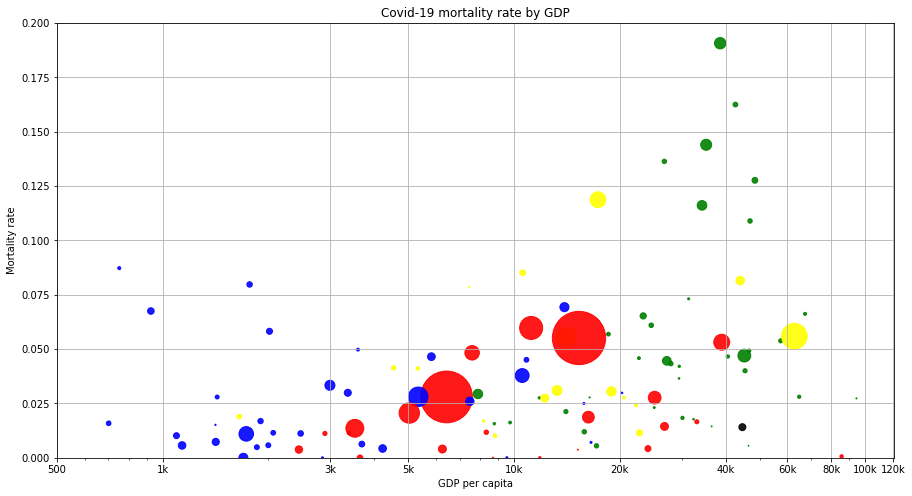

In [37]:
#Figure size
plt.figure(figsize=(15,8))

#Graph kind (x, y, size)
plt.scatter(Data['GDP/capita'], Data['mortality/country'], s=np_pop, c=[continent[i] for i in col], alpha=0.9)

#Grid
plt.grid(True)

#Graph scale
plt.xscale('log')

#Labels
xlab = 'GDP per capita'
ylab = 'Mortality rate'
title = 'Covid-19 mortality rate by GDP'

plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title(title)
plt.ylim([0, 0.2])

#Ticks
tick_val = [500, 1000, 3000, 5000, 10000, 20000, 40000, 60000, 80000, 100000, 120000]
tick_lab = ['500', '1k', '3k', '5k', '10k', '20k', '40k', '60k', '80k', '100k', '120k']
plt.xticks(tick_val, tick_lab)

#plt.plot(X, Y_pred, color='black')

plt.show()

From the graph above, we can see that the mortality rate rises as the GDP increases.
As the countries are in different stages of the pandemic, it is early to tell exactly why that happens and it 
still might change. But one possible explanation is that the number of people in the risk group due to old age
is considerably higher in countries with higher GDPs, as they also have a higher life expectancy.

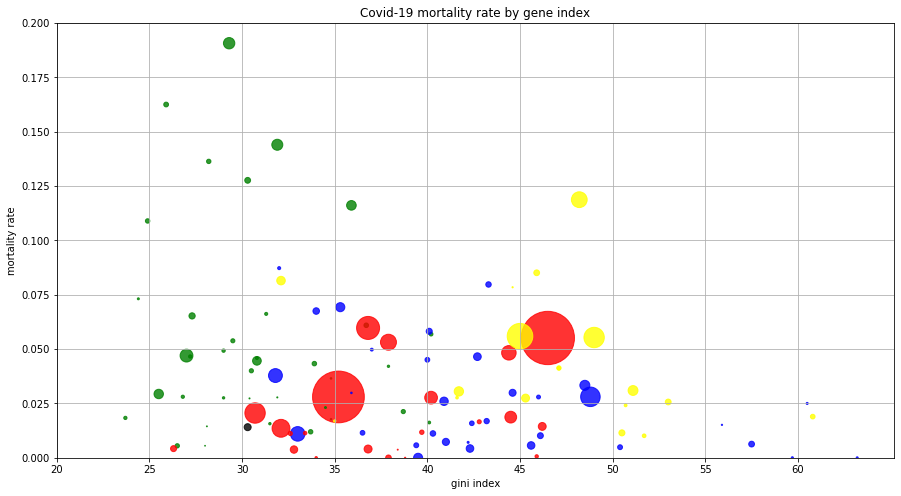

In [38]:
#Figure size
plt.figure(figsize=(15,8))

#Graph kind (x, y, size)
plt.scatter(Data['giniIndex'], Data['mortality/country'], s=np_pop, c=[continent[i] for i in col], alpha=0.8)

#Grid
plt.grid(True)

#Graph scale
#plt.xscale('log')

#Labels
xlab = 'gini index'
ylab = 'mortality rate'
title = 'Covid-19 mortality rate by gene index'

plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title(title)
plt.ylim([0, 0.2])

#Ticks
tick_val_x = list(range(20,61,5))
plt.xticks(tick_val_x)


plt.show()

The gini index is a coefficient that evaluates the wealth distribution in a country. The higher its value, the higher
the inequality in a given country. 
Again, at this stage of the pandemic it might be too early to tell for sure if the data is accurate,
but it is interesting to check how the graph's behavior will change once the pandemic has stabilized everywhere.
We can see that many European countries (in green) are leading the mortality rate in spite of their lower gini index.

# Testing a machine learning classification algorithm

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [40]:
Data['high_mortality'] = (Data['mortality/country'] > 0.1)*1
y = Data['high_mortality'].copy()
class_features = ['GDP/capita', 'PopTotal']
x = Data[class_features].copy()

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=324)

In [42]:
mortality_classifier = DecisionTreeClassifier(max_leaf_nodes=15, random_state=0)
mortality_classifier.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=15,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [43]:
predictions = mortality_classifier.predict(x_test)
predictions

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [46]:
y_test

19     0
5      0
18     0
36     0
55     0
11     0
94     0
4      0
61     0
41     0
85     0
57     0
101    0
69     0
33     1
54     0
93     0
8      0
62     0
49     0
6      0
105    0
87     0
77     1
39     0
27     0
103    0
65     0
95     0
22     0
89     0
100    0
20     0
51     0
43     0
98     0
104    0
Name: high_mortality, dtype: int32

In [44]:
accuracy_score(y_true = y_test, y_pred = predictions)

0.8648648648648649

In [45]:
Data['high_mortality'].value_counts()

0    103
1      8
Name: high_mortality, dtype: int64

In [50]:
np.count_nonzero(predictions)

7

# Testing a Regression algorithm

In [51]:
import sqlite3
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [52]:
regression_features = ['GDP/capita', 'giniIndex']
X = Data[regression_features]

In [53]:
target = ['mortality/country']
Y = Data[target]

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=324)

In [55]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
Y_prediction = regressor.predict(X_test)
Y_prediction

array([[0.06261393],
       [0.06435541],
       [0.02293578],
       [0.06710965],
       [0.01991972],
       [0.02762324],
       [0.05795798],
       [0.03624072],
       [0.10203019],
       [0.02603126],
       [0.02919252],
       [0.04651694],
       [0.0204829 ],
       [0.04190719],
       [0.06046028],
       [0.05149689],
       [0.08451834],
       [0.03181707],
       [0.02397686],
       [0.04683646],
       [0.06481453],
       [0.03976637],
       [0.05074712],
       [0.06726357],
       [0.02013578],
       [0.06681326],
       [0.04257204],
       [0.03626944],
       [0.05841479],
       [0.0306879 ],
       [0.05023145],
       [0.03282648],
       [0.02263245],
       [0.03333606],
       [0.02207877],
       [0.07462162],
       [0.02524201]])

In [57]:
RMSE = sqrt(mean_squared_error(y_true = Y_test, y_pred = Y_prediction))
print(RMSE)

0.0384925966715144


In [58]:
regressor = DecisionTreeRegressor(max_depth=20)
regressor.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [59]:
Y_prediction2 = regressor.predict(X_test)
Y_prediction2

array([0.14396209, 0.14396209, 0.04827789, 0.04659239, 0.02804793,
       0.00403531, 0.16247214, 0.02799312, 0.06618407, 0.04827789,
       0.02126005, 0.06094654, 0.01017812, 0.06094654, 0.13631765,
       0.04659239, 0.05592321, 0.01127753, 0.01687764, 0.01442911,
       0.14396209, 0.16247214, 0.14396209, 0.14396209, 0.01012891,
       0.13631765, 0.05686654, 0.02126005, 0.16247214, 0.05532401,
       0.04659239, 0.0071066 , 0.01687764, 0.02799312, 0.0411449 ,
       0.06618407, 0.00576297])

In [60]:
RMSE = sqrt(mean_squared_error(y_true = Y_test, y_pred = Y_prediction2))
print(RMSE)

0.05588612916461391
